# Hyperopt search analysis notebook
In this notebook the results of various tests of differently approached hyperparameter optimization scripts are presented.

## Methods performance comparison

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In this test time performance of three methods was evaluated. Neural network models were trained with hyperopt, tune (random search) and tune + hyperopt.<BR>
Each script (hyperTR, tuneTR, hypertuneTR) was evaluated four times with 100, 200, 500 and 1000 trainings.<BR><BR>
In first test the only optimized hyperparameter was a combination of input features.

In [2]:
# Load test results
results = pd.read_csv('/home/qlastyonthegol/Documents/tune tester/summary.csv',sep=',')
results.head()

,trials,hyper,tune,tune+hyper,Unnamed: 4,"Exp1: 1 hyper → features, batch=128, epochs 100, patience 10"
0,100,149,56,112,NaN,NaN
1,200,336,102,204,NaN,NaN
2,500,817,243,508,NaN,NaN
3,1000,1643,493,1026,NaN,NaN


Plot time of experiments

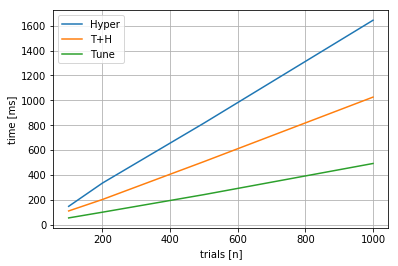

In [3]:
plt.plot(results.trials, results.hyper, label='Hyper')
plt.plot(results.trials, results['tune+hyper'], label='T+H')
plt.plot(results.trials, results.tune, label='Tune')
plt.legend()
plt.xlabel('trials [n]')
plt.ylabel('time [ms]')
plt.grid()

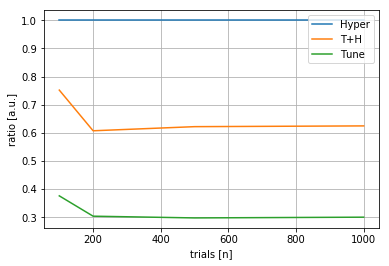

In [4]:
plt.plot(results.trials, results.hyper/results.hyper, label='Hyper')
plt.plot(results.trials, results['tune+hyper']/results.hyper, label='T+H')
plt.plot(results.trials, results.tune/results.hyper, label='Tune')
plt.legend()
plt.xlabel('trials [n]')
plt.ylabel('ratio [a.u.]')
plt.grid()

Clearly pure tune running separate trainings is the fastest. However, in this case it lacks hyperparameter optimization so it is a random search method.<BR>
Anyway, let's load the trainings results.

In [5]:
Rhy = pd.read_csv('/home/qlastyonthegol/PycharmProjects/TESTS/Features 1000/Res_hype.csv',sep=',')
Rtr = pd.read_csv('/home/qlastyonthegol/PycharmProjects/TESTS/Features 1000/Res_tune_rand.csv',sep=',')
Rth = pd.read_csv('/home/qlastyonthegol/PycharmProjects/TESTS/Features 1000/Res_tune_hype.csv',sep=',')

In [6]:
Rhy.describe()

,_features,_acc
count,1000.000000,1000.000000
mean,239.486000,0.778179
std,139.090013,0.063817
min,0.000000,0.503201
25%,117.000000,0.735915
50%,239.500000,0.786172
75%,363.000000,0.823303
max,465.000000,0.882202


In this test there were around 450 combinations of features so 1000 trainings may be not enough to find the best ones. However histograms of random and hyperopt based trainings show that hyperopt preferred some combinations among others.

Text(0.5, 1.0, 'T+H')

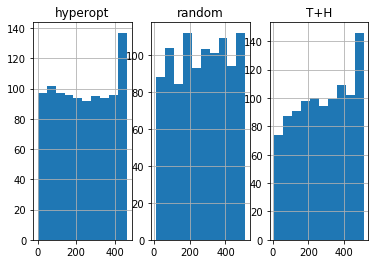

In [7]:
plt.subplot(1,3,1)
Rhy['_features'].hist()
plt.title('hyperopt')

plt.subplot(1,3,2)
Rtr['_features'].hist()
plt.title('random')

plt.subplot(1,3,3)
Rth['_features'].hist()
plt.title('T+H')

If we would like to inspect if we have only pure randomness in our hyperparameter sampling or our framework tries to be smart, regular scatter plots (as below) may be scaracely helpful. There are too many points and not always the trend can be visible (it is hidden in the data or we need more trials).

Text(0.5, 1.0, 'T+H')

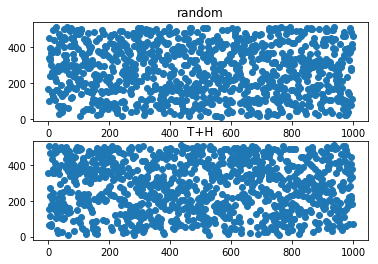

In [8]:
plt.subplot(2,1,1)
plt.scatter(Rtr.index, Rtr['_features'])
plt.title('random')

plt.subplot(2,1,2)
plt.scatter(Rth.index, Rth['_features'])
plt.title('T+H')

This is why we can think of time-histogram, which shows histograms for following portions of data (sampled values of given hyperparameter) in a form of 2D image:

In [9]:
def thist(_data, _steps, _bins):    
    
    _range = [np.min(_data), np.max(_data)]
    step_length = int(len(_data)/_steps)
    
    temp_hist=[]
    for i in range(_steps):
        _counts, _edges =np.histogram(_data[(i)*step_length:(i+1)*step_length],range=_range,bins=_bins)    
        temp_hist.append(_counts)
             
    odp = np.vstack(temp_hist)

    _mids = (_edges[0:-1]+_edges[1:])/2
            
    if(_range[1]>1):
        _mids = np.round(_mids)
        _mids = _mids.astype(int)
    else:
        _mids = np.around(_mids, decimals=4)
        
    plt.imshow(np.transpose(odp), interpolation="none", vmin=0, vmax=9)
    plt.xticks(range(0,_steps),range(1,1+_steps))
    plt.yticks(range(0,_bins), _mids)            
            
    plt.xlabel('steps')
    plt.colorbar()           

So in the example below we can see that the distribution of features combinations in random search is quite even while in hyperopt there is a delicate trace in the panultimate row. But we will look at more exquisite example later.

Text(0.5, 1.0, 'T+H')

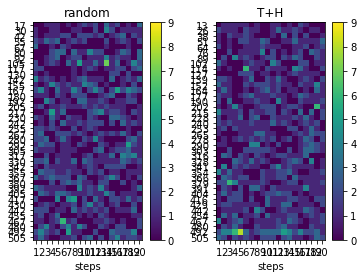

In [10]:
par='_features'
plt.subplot(1,2,1)
thist(Rtr[par], _steps=20, _bins=40)
plt.title('random')

plt.subplot(1,2,2)
thist(Rth[par], _steps=20, _bins=40)
plt.title('T+H')

## Narrowing the set of input combinations
For the sake of having results quicker in the new training session (utilizing hyperopt+tune only) I have considered combinations consisting of 3 up to 5 inputs. 

In [11]:
Rth = pd.read_csv('/home/qlastyonthegol/PycharmProjects/TESTS/Features 3-5/Res_tune_hype.csv',sep=',')

Lines below indicate that combination 105 was the best as the model was trained with the highest accuracy.

In [12]:
howmany=Rth.groupby('_features').size()
howmany[howmany==max(howmany)]

_features
105    54
dtype: int64

In [13]:
Rth.loc[Rth['_features']==105].head(1)

,_features,_acc
180,105,0.869398


In [14]:
max(Rth['_acc'])

0.8693982075790132

## New training with learning rate hyperparameter
In this test the input combination is fixed (105) and the learning rate is of interest. This time I used the hyperopt+tune and random tune scripts.

In [15]:
Rth = pd.read_csv('/home/qlastyonthegol/PycharmProjects/TESTS/LR f105/Res_tune_hype.csv',sep=',')
Rtr = pd.read_csv('/home/qlastyonthegol/PycharmProjects/TESTS/LR f105/Res_tune_rand.csv',sep=',')

Ok, so let's try our **_thist_** function to see the clear difference now.

Text(0.5, 1.0, 'T+H')

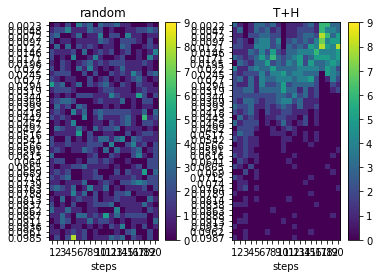

In [16]:
par='_lr'
plt.subplot(1,2,1)
thist(Rtr[par], _steps=20, _bins=40)
plt.title('random')

plt.subplot(1,2,2)
thist(Rth[par], _steps=20, _bins=40)
plt.title('T+H')

In [17]:
Rth = pd.read_csv('/home/qlastyonthegol/PycharmProjects/TESTS/LR a l1 l2/Res_tune_hype.csv',sep=',')
Rtr = pd.read_csv('/home/qlastyonthegol/PycharmProjects/TESTS/LR a l1 l2/Res_tune_rand.csv',sep=',')

In [18]:
Rtr.describe()

,_l1nn,_l2nn,_lr,_acc
count,1000.000000,1000.000000,1000.000000,1000.000000
mean,4.007000,3.985000,0.048938,0.834152
std,2.659328,2.573596,0.029063,0.075861
min,0.000000,0.000000,0.001154,0.306018
25%,2.000000,2.000000,0.022818,0.825864
50%,4.000000,4.000000,0.049162,0.850192
75%,6.000000,6.000000,0.073893,0.868118
max,8.000000,8.000000,0.099938,0.901408


In [19]:
Rth.describe()

,_l1nn,_l2nn,_lr,_acc
count,1000.000000,1000.00000,1000.000000,1000.000000
mean,3.799000,4.46900,0.020150,0.858629
std,2.287757,2.18628,0.010763,0.029176
min,0.000000,0.00000,0.001002,0.696543
25%,2.000000,3.00000,0.011857,0.846351
50%,3.000000,5.00000,0.018400,0.865557
75%,6.000000,6.00000,0.027571,0.879641
max,8.000000,8.00000,0.049799,0.903969


In [20]:
tuh=[]
tra=[]

for i in range(10,101,1):        
    tuh.append( Rth.loc[Rth['_acc']<i/100].count()[0] )
    tra.append( Rtr.loc[Rtr['_acc']<i/100].count()[0] )

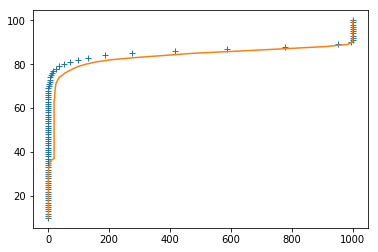

In [21]:
plt.plot(tuh, range(10,101,1),'+')
plt.plot(tra, range(10,101,1))